In [1]:
# dependencies
import os, math, time, random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
 
import cv2
from glob import glob
import tensorflow as tf
from sklearn.utils import shuffle

 # skimage
from skimage.io import imread 
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import data, color

# pil
from PIL import Image as pil_image

import warnings
warnings.filterwarnings("ignore")

# from keras
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential
from keras.layers import  MaxPooling2D, BatchNormalization, Flatten
from keras.layers import Input, Conv2D, Activation,  MaxPool2D, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.merge import add
from keras.activations import relu, sigmoid
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.vgg16 import VGG16
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam
#from keras.applications.resnet import ResNet101

# scikit learn helper functions
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
IMG_SIZE = 32 # in the given original size

In [3]:
print('Given files: ', os.listdir('../input/'))
# data shapes
print('train images: ', len(os.listdir('../input/train/train')))
print('test images: ', len(os.listdir('../input/test/test')))

# folders
train_folder = '../input/train/train'
test_folder = '../input/test/test'
train_df = pd.read_csv('../input/train.csv')

Given files:  ['test', 'train', 'train.csv', 'sample_submission.csv']
train images:  17500
test images:  4000


In [4]:
train_images_path = glob('../input/train/train/*.jpg')
test_images_path = glob('../input/test/test/*.jpg')

In [5]:
# retunrs a complete path to a image with Image name
def expand_path(path):
    if os.path.isfile('../input/train/train/' + path):
        return '../input/train/train/' + path
    if os.path.isfile('../input/test/test/' + path):
        return '../input/test/test/' + path
    return path

# returns a resized black and white PIL Image object
def pil_image_load(image):
    image_path = expand_path(image)
    image = pil_image.open(image_path)#.convert('L')
    return image.resize((IMG_SIZE, IMG_SIZE))
    #return image
    
# load the resized image
def read_image(img_path, resized_shape=None):
    # expanding img_path to complete image path
    img_path = expand_path(img_path)
    image = imread(img_path)
    gray_image = color.rgb2gray(image)
    rgb_image = color.gray2rgb(gray_image)
    if resized_shape:
        image_resized = resize(rgb_image,(resized_shape,resized_shape, 3))
        return image_resized[:,:]/255
    return rgb_image[:,:]/255

In [6]:
# train data dataframe
train_df['image'] = train_df['id'].apply(lambda path: read_image(path))

# creating test dataframe
test_df = pd.DataFrame(columns=["id", "image"])
test_df['id'] = os.listdir('../input/test/test/')
test_df['image'] = test_df['id'].apply(lambda path: read_image(path))

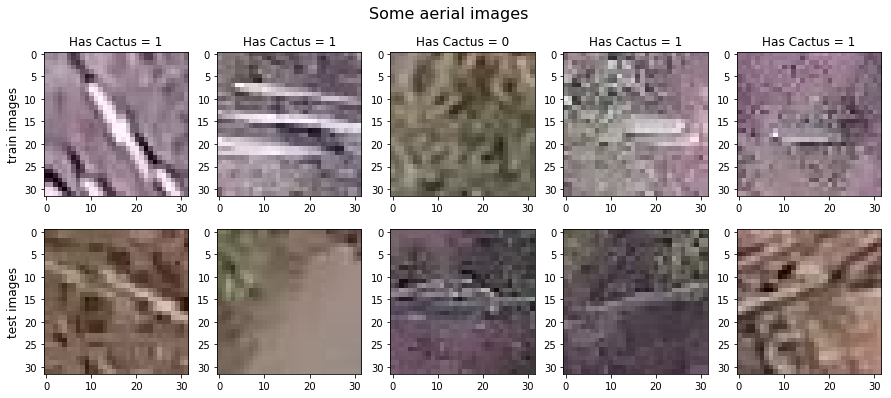

In [7]:
# some visualizations 
random.shuffle(train_images_path)
fig, ax = plt.subplots(2,5, figsize=(15,6))
fig.suptitle('Some aerial images',fontsize=16)

df = shuffle(train_df)
for i, item in enumerate(df.values[15:20]):
    image = pil_image.open(expand_path(item[0]))
    ax[0,i].imshow(image)
    ax[0, i].set_title('Has Cactus = %d' % (item[1]))
ax[0,0].set_ylabel('train images', size='large')

for i, path in enumerate(test_images_path[:5]):
    image = pil_image.open(path)
    #image = image.resize((IMG_SIZE, IMG_SIZE))
    ax[1,i].imshow(image)
ax[1,0].set_ylabel('test images', size='large');

In [8]:
# CNN model
def CNN():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides = (1, 1), input_shape = (IMG_SIZE, IMG_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), strides = (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), strides = (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # fully connected layer
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    
    # output
    model.add(Dense(1, activation='sigmoid'))
    
    # compiling
    model.compile(loss='binary_crossentropy', optimizer=optimizers.rmsprop(), metrics=['accuracy'])
    return model

In [9]:
# Ref: https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb
def NASNetMoibleClassifier():
    inputs = Input((IMG_SIZE, IMG_SIZE, 3))
    base_model = NASNetMobile(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))#, weights=None
    x = base_model(inputs)
    
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="softmax")(out)
    
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model

In [10]:
# Ref: https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb
def VGGModel():
    model_vg = VGG16(weights='imagenet',include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    #model_vg.trainable = False
    
    model = Sequential()
    model.add(model_vg)
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [11]:
# returns a batch of image for training
def train_batch(train_df):
    batch_size = train_df.shape[0]
    images = train_df.image.values
    first_image = images[0]
    x_train = []
    y_train = train_df.has_cactus.values
    for i, image in enumerate(images):
        x_train.append(image.tolist())
    x_train = np.array(x_train)
    y_train = y_train.reshape(len(y_train), 1)
    return x_train, y_train

In [12]:
# model = CNN()
# model.summary()

In [13]:
# training data
# X_train, y_train = train_batch(train_df)

In [14]:
 # batch train (with batch load) the model with training data
def train_model(model, X_train, y_train, epochs=5, verbose=None):
    begin = time.time()
    # checkpoint
    checkpointer = ModelCheckpoint(filepath='weights.hdf5', monitor='val_acc', verbose=0, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)
    for i in range(1, epochs + 1):
        #print('************************************')
        #print('Epoch: ', i, '/', epochs)
        #print('************************************')
        if verbose:
            verbose = verbose
        # fitting
        model.fit(X_train, y_train, verbose=verbose, callbacks=[checkpointer, early_stopping], validation_split=0.1, shuffle=True)     
    # done!
    elapsed = time.time() - begin
    print('total training time: ', elapsed)
    return model

# training
# md = train_model(model, X_train, y_train, epochs=30, verbose=1);

In [15]:
# Test prediction data preparation
# test_images = []
# for image in test_df.image.values:
#     test_images.append(image)
# X_test = np.array(test_images)

# # prediction on test data
# y_pred = md.predict(X_test)
# y_test = (y_pred.flatten() > 0.5).astype('int8')

# # submission file preparation
# submission=pd.DataFrame({'id':test_df['id']})
# submission['has_cactus']=y_test

# # submitting the results
# submission.to_csv("submission.csv",index=False)

# With fast.ai

In [16]:
%reload_ext autoreload
%autoreload 2

In [17]:
from fastai.vision import *
from fastai.metrics import error_rate

In [18]:
bs = 64

In [20]:
path = Path("../input")
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [21]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/sample_submission.csv")

In [23]:
np.random.seed(2000)
data = (ImageList.from_df(train_df, path=path/'train', folder='train')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .transform(tfms, size=128)
        .databunch(path='.', bs=bs, device= torch.device('cuda:0'))
       ).normalize(imagenet_stats)

In [24]:
learn = cnn_learner(data, models.densenet161, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:10, 10944385.05it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


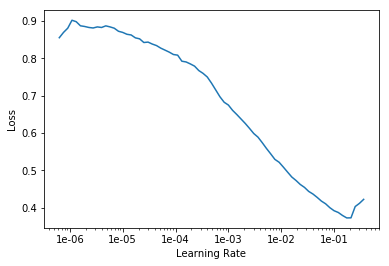

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
# learning rate from graph
lr = 0.003
learn.fit_one_cycle(5, slice(lr, 0.05))

epoch,train_loss,valid_loss,error_rate,time
0,0.046219,0.681208,0.074286,01:18
1,0.076268,0.004179,0.000000,01:17
2,0.035256,0.000028,0.000000,01:19
3,0.010905,0.000013,0.000000,01:15
4,0.002261,0.000005,0.000000,01:17


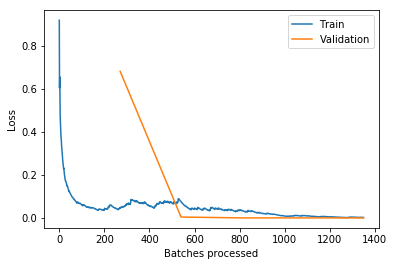

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [33]:
#learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.001877,0.000014,0.000000,01:29
1,0.002338,0.000022,0.000000,01:29
2,0.001987,0.000012,0.000000,01:28
3,0.001736,0.000005,0.000000,01:29
4,0.004266,0.000004,0.000000,01:28


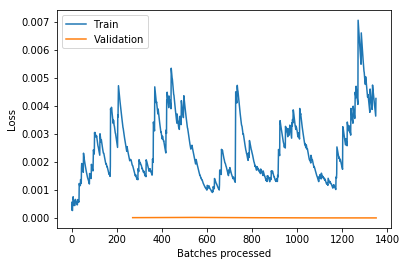

In [32]:
learn.recorder.plot_losses()

In [ ]:
# test prediction

In [ ]:
test_data = ImageList.from_df(test_df, path=path/'test', folder='test')
data.add_test(test_data)

In [ ]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
test_df.has_cactus = preds.numpy()[:, 0]

In [ ]:
test_df.head()

In [ ]:
test_df.to_csv("submission.csv", index=False)